<a href="https://colab.research.google.com/github/arasavillihemalatha31/FUTURE_ML_02/blob/main/FUTURE_ML_02_StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --quiet
!pip install keras --quiet


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [ ]:
# Download AAPL stock data (last 5 years)
df = yf.download("AAPL", start="2018-01-01", end="2023-12-31")
df = df[['Close']]  # Use 'Close' price only
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Close
Ticker,AAPL
Date,


In [ ]:
# Create dummy stock data
dates = pd.date_range(start="2022-01-01", periods=500)
prices = np.linspace(150, 200, num=500) + np.random.normal(0, 2, 500)
df = pd.DataFrame({"Close": prices}, index=dates)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])


In [ ]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 60  # 60-day lookback window
X, y = create_sequences(scaled_data, seq_len)


In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape inputs for LSTM: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.1897 - val_loss: 0.0101
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0197 - val_loss: 0.0356
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0012 - val_loss: 9.7431e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0012 - val_loss: 9.3763e-04


In [ ]:
y_pred = model.predict(X_test)

# Inverse scale predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 497ms/step


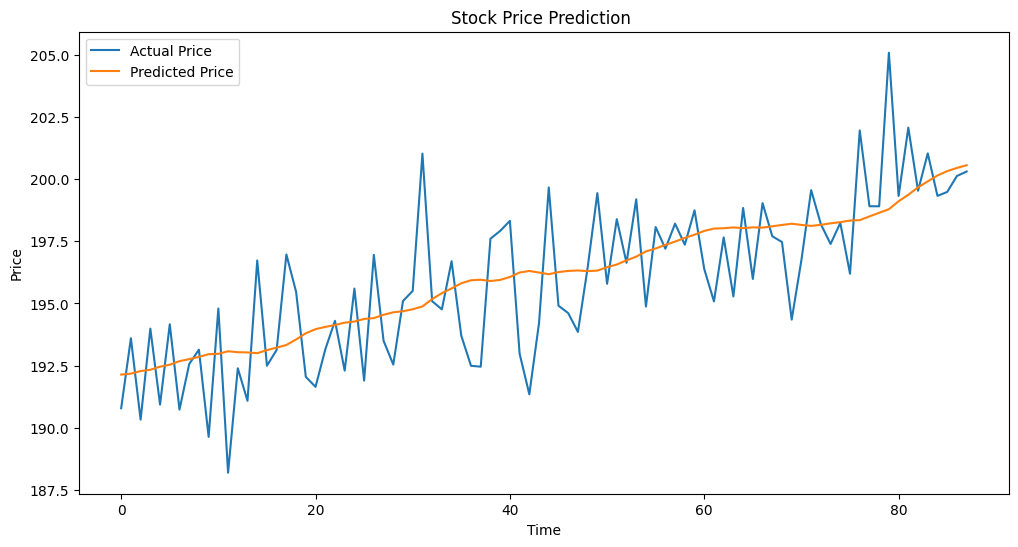

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price')
plt.title('Stock Price Prediction ')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
plt.savefig("stock_prediction_plot.png")
